<a href="https://colab.research.google.com/github/ykitaguchi77/FundusPhoto/blob/main/RandomForest_and_XGBoost_1.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#google driveをcolabolatoryにマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import seaborn as sns
import statsmodels.api as sm
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Deep_learning/FundusPhoto/result_5_GaussianBlur.csv", index_col=0, sep=",")
df


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,age,cropped_2_A2_GaussianBlur_pretrained_0,cropped_2_A2_GaussianBlur_pretrained_1,cropped_2_A2_GaussianBlur_pretrained_2,cropped_2_A2_GaussianBlur_pretrained_3,cropped_2_A2_GaussianBlur_pretrained_4,disc_2_A2_GaussianBlur_pretrained_0,disc_2_A2_GaussianBlur_pretrained_1,disc_2_A2_GaussianBlur_pretrained_2,disc_2_A2_GaussianBlur_pretrained_3,disc_2_A2_GaussianBlur_pretrained_4,macula_2_A2_GaussianBlur_pretrained_0,macula_2_A2_GaussianBlur_pretrained_1,macula_2_A2_GaussianBlur_pretrained_2,macula_2_A2_GaussianBlur_pretrained_3,macula_2_A2_GaussianBlur_pretrained_4
filename,,,,,,,,,,,,,,,,
img00085008_00_1R.jpg,61,60.885948,60.356665,50.935251,59.631753,58.965695,45.052648,60.332221,61.809397,59.062302,68.153375,51.562381,58.757454,68.297571,59.610933,55.720055
img00085024_00_1R.jpg,29,29.766262,30.331397,29.118884,31.672752,30.989829,26.809660,32.241669,30.086446,30.817971,32.113385,26.403788,27.999404,31.571031,26.205668,21.942243
img00241280_10_1R.jpg,51,58.364809,50.553083,63.250524,54.238850,50.851762,63.289428,54.653805,49.245375,50.571257,57.794720,49.765614,49.845201,54.795003,59.864140,54.611915
img00265140_00_1R.jpg,29,32.213056,31.123018,29.923308,31.866950,31.424466,33.026874,27.775347,31.257206,30.184183,31.335768,28.773826,28.549322,29.491693,27.227801,29.133636
img00265140_00_2L.jpg,29,32.485062,31.811762,30.549696,32.765386,31.352851,35.573980,32.451853,30.288148,31.099230,30.537629,29.595745,27.726558,31.044161,32.806641,29.797870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
img76791392_10_1R.jpg,38,38.199157,39.335907,38.415360,40.701389,37.806478,37.474301,32.679823,31.805116,37.843254,33.726096,36.371392,49.667397,39.193630,38.588050,34.526837
img76843122_10_1R.jpg,49,53.196847,45.640141,45.546347,51.625419,50.128996,48.410195,42.230716,46.253222,51.311338,51.198155,48.310232,45.538834,44.979483,52.453923,44.837600
img76843122_11_1R.jpg,49,56.886828,50.544816,47.587875,52.457392,50.793570,52.799886,45.932961,44.371003,51.916403,50.504851,44.726014,42.309937,45.024800,40.706378,42.950150


In [ ]:
import seaborn as sns
import statsmodels.api as sm
import pandas as pd

import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import sklearn; 


#sorted(sklearn.metrics.SCORERS.keys())


#indexの内容を確認
#print(df.columns.values.tolist())


FEATURE_COLS=df.columns.values[3:].tolist()


"""
FEATURE_COLS=[
 'cropped_A2',
 'cropped_B3']
"""

print(FEATURE_COLS)

# 訓練データとテストデータに分割する。
from sklearn.model_selection import train_test_split
# TODO:層別サンプリング train, test = train_test_split(df, test_size=0.20, stratify=df["町区分"], random_state=100)
train, test = train_test_split(df, test_size=0.20,random_state=100)

X_train = train[FEATURE_COLS]
Y_train = train["age"]
X_test = test[FEATURE_COLS]
Y_test = test["age"]


['cropped_2_A2_GaussianBlur_pretrained_2', 'cropped_2_A2_GaussianBlur_pretrained_3', 'cropped_2_A2_GaussianBlur_pretrained_4', 'disc_2_A2_GaussianBlur_pretrained_0', 'disc_2_A2_GaussianBlur_pretrained_1', 'disc_2_A2_GaussianBlur_pretrained_2', 'disc_2_A2_GaussianBlur_pretrained_3', 'disc_2_A2_GaussianBlur_pretrained_4', 'macula_2_A2_GaussianBlur_pretrained_0', 'macula_2_A2_GaussianBlur_pretrained_1', 'macula_2_A2_GaussianBlur_pretrained_2', 'macula_2_A2_GaussianBlur_pretrained_3', 'macula_2_A2_GaussianBlur_pretrained_4']


#**Prediction accuracy for each model**

In [ ]:
import seaborn as sns
import statsmodels.api as sm
import pandas as pd

import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import sklearn; 


#　　精度確認
# 自由度調整済みr2を算出
def adjusted_r2(X,Y):
    from sklearn.metrics import r2_score
    import numpy as np
    r_squared = r2_score(Y, X)
    adjusted_r2 = 1 - (1-r_squared)*(len(Y)-1)/(len(Y)-2)
    #yhat = model.predict(X) \ #SS_Residual = sum((Y-yhat)**2) \ #SS_Total = sum((Y-np.mean(Y))**2)
    #r_squared = 1 - (float(SS_Residual))/ SS_Total
    return adjusted_r2

# 予測モデルの精度確認の各種指標を算出
def get_model_evaluations(X_train,Y_train,X_test,Y_test):
    from sklearn.metrics import explained_variance_score
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_squared_log_error
    from sklearn.metrics import median_absolute_error

   # 評価指標確認
   # 参考: https://funatsu-lab.github.io/open-course-ware/basic-theory/accuracy-index/
    yhat_test = X_test

    print("adjusted_r2(train)     :" + str(adjusted_r2(X_train,Y_train)))
    print("adjusted_r2(test)      :" + str(adjusted_r2(X_test,Y_test)))   
    #print("平均誤差率(test)       :" + str(np.mean(abs(Y_test / yhat_test - 1)))) 
    print("MAE(test)              :" + str(mean_absolute_error(Y_test, yhat_test)))
    print("MedianAE(test)         :" + str(median_absolute_error(Y_test, yhat_test)))
    print("RMSE(test)             :" + str(np.sqrt(mean_squared_error(Y_test, yhat_test))))
    print("RMSE(test) / MAE(test) :" + str(np.sqrt(mean_squared_error(Y_test, yhat_test)) / mean_absolute_error(Y_test, yhat_test))) #better if result = 1.253

for i in FEATURE_COLS:
    X_train = train[i]
    Y_train = train["age"]
    X_test = test[i]
    Y_test = test["age"]
    print(str(i))
    get_model_evaluations(X_train,Y_train,X_test,Y_test)
    print("")

#後の解析のためにそれぞれの項目を戻しておく
X_train = train[FEATURE_COLS]
Y_train = train["age"]
X_test = test[FEATURE_COLS]
Y_test = test["age"]

cropped_2_A2_GaussianBlur_pretrained_2
adjusted_r2(train)     :0.9389912075212472
adjusted_r2(test)      :0.9393244316365672
MAE(test)              :2.430253053933067
MedianAE(test)         :1.68729829788208
RMSE(test)             :3.7548055256776744
RMSE(test) / MAE(test) :1.5450265640448355

cropped_2_A2_GaussianBlur_pretrained_3
adjusted_r2(train)     :0.9292631588281818
adjusted_r2(test)      :0.9373649164607261
MAE(test)              :2.833899311379072
MedianAE(test)         :2.2235801219940257
RMSE(test)             :3.8149544088856104
RMSE(test) / MAE(test) :1.3461855873168351

cropped_2_A2_GaussianBlur_pretrained_4
adjusted_r2(train)     :0.9192829962844628
adjusted_r2(test)      :0.9016889417889322
MAE(test)              :3.0271323780288966
MedianAE(test)         :2.0113089084625244
RMSE(test)             :4.779491649288967
RMSE(test) / MAE(test) :1.5788842549400204

disc_2_A2_GaussianBlur_pretrained_0
adjusted_r2(train)     :0.8951946403251693
adjusted_r2(test)      :0.889281

#**Analysis using XGBoost**
https://hinomaruc.hatenablog.com/entry/2019/12/07/000022

In [ ]:
# Grid Search用のパラメータ作成。
# あまり組み合わせが多いと時間がかかる(time consuming)
params = {
        'eta': [0.01],             # default = 0.3      
        'gamma': [1,2,3],            # default = 0
        'max_depth': [7,8,9],      # default = 6
        'min_child_weight': [1],   # default = 1
        'subsample': [0.8,1.0],        # default = 1
        'colsample_bytree': [0.8,1.0], # default = 1
        }
kf = KFold(n_splits=5, shuffle = True, random_state = 1)

#最適解探索
model = xgb.XGBRegressor(objective ='reg:squarederror')
grid = GridSearchCV(estimator=model, param_grid=params, scoring='neg_mean_squared_error', n_jobs=2, cv=kf.split(X_train,Y_train), verbose=3)


grid.fit(X_train,Y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    6.4s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   24.7s
[Parallel(n_jobs=2)]: Done 180 out of 180 | elapsed:   36.1s finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f128a2d8650>,
             error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    object...
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=2,
             param_grid={'colsample_bytree': [0.8, 1.0], 'eta': [0.01],
            

In [ ]:
print('ベストスコア:',grid.best_score_, sep="\n")
print('\n')
print('ベストestimator:',grid.best_estimator_,sep="\n")
print('\n')
print('ベストparams:',grid.best_params_,sep="\n")

print(pd.DataFrame(grid.cv_results_))

In [ ]:
# 自由度調整済みr2を算出
def adjusted_r2(X,Y,model):
    from sklearn.metrics import r2_score
    import numpy as np
    r_squared = r2_score(Y, model.predict(X))
    adjusted_r2 = 1 - (1-r_squared)*(len(Y)-1)/(len(Y)-X.shape[1]-1)
    #yhat = model.predict(X) \ #SS_Residual = sum((Y-yhat)**2) \ #SS_Total = sum((Y-np.mean(Y))**2)
    #r_squared = 1 - (float(SS_Residual))/ SS_Total
    return adjusted_r2

# 予測モデルの精度確認の各種指標を算出
def get_model_evaluations(X_train,Y_train,X_test,Y_test,model):
    from sklearn.metrics import explained_variance_score
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_squared_log_error
    from sklearn.metrics import median_absolute_error

   # 評価指標確認
   # 参考: https://funatsu-lab.github.io/open-course-ware/basic-theory/accuracy-index/
    yhat_test = model.predict(X_test)
    return "adjusted_r2(train)     :" + str(adjusted_r2(X_train,Y_train,model)) \
         , "adjusted_r2(test)      :" + str(adjusted_r2(X_test,Y_test,model)) \
         , "平均誤差率(test)       :" + str(np.mean(abs(Y_test / yhat_test - 1))) \
         , "MAE(test)              :" + str(mean_absolute_error(Y_test, yhat_test)) \
         , "MedianAE(test)         :" + str(median_absolute_error(Y_test, yhat_test)) \
         , "RMSE(test)             :" + str(np.sqrt(mean_squared_error(Y_test, yhat_test))) \
         , "RMSE(test) / MAE(test) :" + str(np.sqrt(mean_squared_error(Y_test, yhat_test)) / mean_absolute_error(Y_test, yhat_test)) #better if result = 1.253



# Grid Searchで一番精度が良かったモデル
bestmodel = grid.best_estimator_

get_model_evaluations(X_train,Y_train,X_test,Y_test,bestmodel)


('adjusted_r2(train)     :0.9993478599620208',
 'adjusted_r2(test)      :0.990693364235288',
 '平均誤差率(test)       :0.02016066320491555',
 'MAE(test)              :1.077954228269759',
 'MedianAE(test)         :0.8284568786621094',
 'RMSE(test)             :1.438798115683463',
 'RMSE(test) / MAE(test) :1.334748802825237')

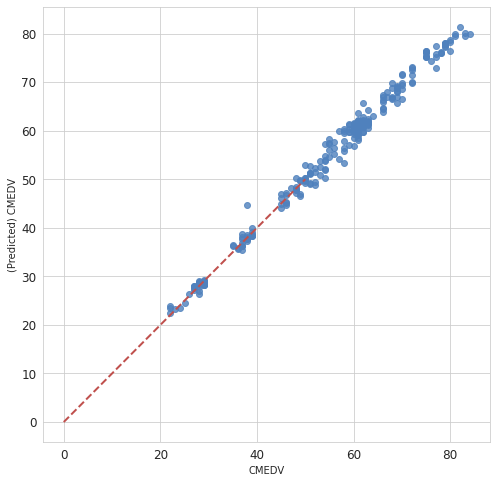

In [ ]:
# 描画設定
from matplotlib import rcParams
rcParams['xtick.labelsize'] = 12       # x軸のラベルのフォントサイズ
rcParams['ytick.labelsize'] = 12       # y軸のラベルのフォントサイズ
rcParams['figure.figsize'] = 8,8      # 画像サイズの変更(inch)

import matplotlib.pyplot as plt
from matplotlib import ticker
sns.set_style("whitegrid")             # seabornのスタイルセットの一つ
sns.set_color_codes()                  # デフォルトカラー設定 (deepになってる)

plt.figure()
ax = sns.regplot(x=Y_test, y=bestmodel.predict(X_test), fit_reg=False,color='#4F81BD')
ax.set_xlabel(u"CMEDV")
ax.set_ylabel(u"(Predicted) CMEDV")
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda y, p: format(int(y), ',')))
ax.plot([0,10,20,30,40,50],[0,10,20,30,40,50], linewidth=2, color="#C0504D",ls="--")

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

features = X_train.columns
importances = bestmodel.feature_importances_
indices = np.argsort(importances)

"""
plt.figure(figsize=(6,6))
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.show()
"""

feature_importances = pd.DataFrame([features, importances]).T
feature_importances.columns = ['features', 'importances']
df_s = feature_importances.sort_values('importances', ascending=False).reset_index(drop=True)
df_s


In [ ]:
xgb.plot_importance(bestmodel, importance_type='gain')

In [ ]:
xgb.plot_importance(bestmodel, importance_type='weight')

In [ ]:
xgb.to_graphviz(bestmodel, num_trees=5)


#**Analysis using RandomForest**
https://hinomaruc.hatenablog.com/entry/2019/11/14/200857

In [ ]:
#Create model
import numpy as np
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=10)
model.fit(X_train,Y_train) 

"""
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=2525, verbose=0, warm_start=False)
"""



#　　精度確認
# 自由度調整済みr2を算出
def adjusted_r2(X,Y,model):
    from sklearn.metrics import r2_score
    import numpy as np
    r_squared = r2_score(Y, model.predict(X))
    adjusted_r2 = 1 - (1-r_squared)*(len(Y)-1)/(len(Y)-X.shape[1]-1)
    #yhat = model.predict(X) \ #SS_Residual = sum((Y-yhat)**2) \ #SS_Total = sum((Y-np.mean(Y))**2)
    #r_squared = 1 - (float(SS_Residual))/ SS_Total
    return adjusted_r2

# 予測モデルの精度確認の各種指標を算出
def get_model_evaluations(X_train,Y_train,X_test,Y_test,model):
    from sklearn.metrics import explained_variance_score
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_squared_log_error
    from sklearn.metrics import median_absolute_error

   # 評価指標確認
   # 参考: https://funatsu-lab.github.io/open-course-ware/basic-theory/accuracy-index/
    yhat_test = model.predict(X_test)
    return "adjusted_r2(train)     :" + str(adjusted_r2(X_train,Y_train,model)) \
         , "adjusted_r2(test)      :" + str(adjusted_r2(X_test,Y_test,model)) \
         , "平均誤差率(test)       :" + str(np.mean(abs(Y_test / yhat_test - 1))) \
         , "MAE(test)              :" + str(mean_absolute_error(Y_test, yhat_test)) \
         , "MedianAE(test)         :" + str(median_absolute_error(Y_test, yhat_test)) \
         , "RMSE(test)             :" + str(np.sqrt(mean_squared_error(Y_test, yhat_test))) \
         , "RMSE(test) / MAE(test) :" + str(np.sqrt(mean_squared_error(Y_test, yhat_test)) / mean_absolute_error(Y_test, yhat_test)) #better if result = 1.253

def get_model_result(X_test, model):
    yhat_test = model.predict(X_test)
    return yhat_test


get_model_evaluations(X_train,Y_train,X_test,Y_test,model)

('adjusted_r2(train)     :0.995472699606932',
 'adjusted_r2(test)      :0.9744906081902907',
 '平均誤差率(test)       :0.029717351704425098',
 'MAE(test)              :1.5296819787985867',
 'MedianAE(test)         :1.0',
 'RMSE(test)             :2.259358237784152',
 'RMSE(test) / MAE(test) :1.4770117377983714')

In [ ]:
#Grid search
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train,Y_train)



print('ベストスコア:',grid.best_score_, sep="\n")
print('\n')
print('ベストestimator:',grid.best_estimator_,sep="\n")
print('\n')
print('ベストparams:',grid.best_params_,sep="\n")

print(pd.DataFrame(grid.cv_results_))

# Grid Searchで一番精度が良かったモデル
bestmodel = grid.best_estimator_
get_model_evaluations(X_train,Y_train,X_test,Y_test,bestmodel)

NameError: ignored

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

features = X_train.columns
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(6,6))
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.show()


feature_importances = pd.DataFrame([features, importances]).T
feature_importances.columns = ['features', 'importances']
df_s = feature_importances.sort_values('importances', ascending=False).reset_index(drop=True)
df_s

In [ ]:
"""
plt.figure(figsize=(8,8))
plt.title('Importances')
plt.rcParams['font.size']=10
sns.barplot(y='features', x='importances', data=df_s, palette='viridis')
"""

In [ ]:
# 描画設定
from matplotlib import rcParams
rcParams['xtick.labelsize'] = 12       # x軸のラベルのフォントサイズ
rcParams['ytick.labelsize'] = 12       # y軸のラベルのフォントサイズ
rcParams['figure.figsize'] = 8,8      # 画像サイズの変更(inch)

import matplotlib.pyplot as plt
from matplotlib import ticker
sns.set_style("whitegrid")             # seabornのスタイルセットの一つ
sns.set_color_codes()                  # デフォルトカラー設定 (deepになってる)

plt.figure()
ax = sns.regplot(x=Y_test, y=model.predict(X_test), fit_reg=False,color='#4F81BD')
ax.set_xlabel(u"True Age")
ax.set_ylabel(u"Predicted Age")
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda y, p: format(int(y), ',')))
ax.plot([0,10,20,30,40,50],[0,10,20,30,40,50], linewidth=2, color="#C0504D",ls="--")

#**Analysis using neural network**

In [ ]:
#正規化する
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)

#モデル作成
import numpy as np
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(alpha=0.1, hidden_layer_sizes=(100, 100, 100), learning_rate='adaptive', max_iter=500, random_state=42, solver="lbfgs", early_stopping=True) 
model.fit(X_train,Y_train) 


"""
初期設定：

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
"""


# 自由度調整済みr2を算出
def adjusted_r2(X,Y,model):
    from sklearn.metrics import r2_score
    import numpy as np
    r_squared = r2_score(Y, model.predict(X))
    adjusted_r2 = 1 - (1-r_squared)*(len(Y)-1)/(len(Y)-X.shape[1]-1)
    #yhat = model.predict(X) \ #SS_Residual = sum((Y-yhat)**2) \ #SS_Total = sum((Y-np.mean(Y))**2)
    #r_squared = 1 - (float(SS_Residual))/ SS_Total
    return adjusted_r2

# 予測モデルの精度確認の各種指標を算出
def get_model_evaluations(X_train,Y_train,X_test,Y_test,model):
    from sklearn.metrics import explained_variance_score
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_squared_log_error
    from sklearn.metrics import median_absolute_error

   # 評価指標確認
   # 参考: https://funatsu-lab.github.io/open-course-ware/basic-theory/accuracy-index/
    yhat_test = model.predict(X_test)
    return "adjusted_r2(train)     :" + str(adjusted_r2(X_train,Y_train,model)) \
         , "adjusted_r2(test)      :" + str(adjusted_r2(X_test,Y_test,model)) \
         , "平均誤差率(test)       :" + str(np.mean(abs(Y_test / yhat_test - 1))) \
         , "MAE(test)              :" + str(mean_absolute_error(Y_test, yhat_test)) \
         , "MedianAE(test)         :" + str(median_absolute_error(Y_test, yhat_test)) \
         , "RMSE(test)             :" + str(np.sqrt(mean_squared_error(Y_test, yhat_test))) \
         , "RMSE(test) / MAE(test) :" + str(np.sqrt(mean_squared_error(Y_test, yhat_test)) / mean_absolute_error(Y_test, yhat_test)) #better if result = 1.253

get_model_evaluations(X_train,Y_train,X_test,Y_test,model)

In [ ]:
# 描画設定
from matplotlib import rcParams
rcParams['xtick.labelsize'] = 12       # x軸のラベルのフォントサイズ
rcParams['ytick.labelsize'] = 12       # y軸のラベルのフォントサイズ
rcParams['figure.figsize'] = 8,8      # 画像サイズの変更(inch)

import matplotlib.pyplot as plt
from matplotlib import ticker
sns.set_style("whitegrid")             # seabornのスタイルセットの一つ
sns.set_color_codes()                  # デフォルトカラー設定 (deepになってる)

plt.figure()
ax = sns.regplot(x=Y_test, y=model.predict(X_test), fit_reg=False,color='#4F81BD')
ax.set_xlabel(u"True Age")
ax.set_ylabel(u"Predicted Age")
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda y, p: format(int(y), ',')))
ax.plot([0,10,20,30,40,50],[0,10,20,30,40,50], linewidth=2, color="#C0504D",ls="--")

#**Predict age from test dataset**

In [12]:
df

,age,cropped_2_A2_GaussianBlur_pretrained_0,cropped_2_A2_GaussianBlur_pretrained_1,cropped_2_A2_GaussianBlur_pretrained_2,cropped_2_A2_GaussianBlur_pretrained_3,cropped_2_A2_GaussianBlur_pretrained_4,disc_2_A2_GaussianBlur_pretrained_0,disc_2_A2_GaussianBlur_pretrained_1,disc_2_A2_GaussianBlur_pretrained_2,disc_2_A2_GaussianBlur_pretrained_3,disc_2_A2_GaussianBlur_pretrained_4,macula_2_A2_GaussianBlur_pretrained_0,macula_2_A2_GaussianBlur_pretrained_1,macula_2_A2_GaussianBlur_pretrained_2,macula_2_A2_GaussianBlur_pretrained_3,macula_2_A2_GaussianBlur_pretrained_4
filename,,,,,,,,,,,,,,,,
img00085008_00_1R.jpg,61,60.885948,60.356665,50.935251,59.631753,58.965695,45.052648,60.332221,61.809397,59.062302,68.153375,51.562381,58.757454,68.297571,59.610933,55.720055
img00085024_00_1R.jpg,29,29.766262,30.331397,29.118884,31.672752,30.989829,26.809660,32.241669,30.086446,30.817971,32.113385,26.403788,27.999404,31.571031,26.205668,21.942243
img00241280_10_1R.jpg,51,58.364809,50.553083,63.250524,54.238850,50.851762,63.289428,54.653805,49.245375,50.571257,57.794720,49.765614,49.845201,54.795003,59.864140,54.611915
img00265140_00_1R.jpg,29,32.213056,31.123018,29.923308,31.866950,31.424466,33.026874,27.775347,31.257206,30.184183,31.335768,28.773826,28.549322,29.491693,27.227801,29.133636
img00265140_00_2L.jpg,29,32.485062,31.811762,30.549696,32.765386,31.352851,35.573980,32.451853,30.288148,31.099230,30.537629,29.595745,27.726558,31.044161,32.806641,29.797870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
img76791392_10_1R.jpg,38,38.199157,39.335907,38.415360,40.701389,37.806478,37.474301,32.679823,31.805116,37.843254,33.726096,36.371392,49.667397,39.193630,38.588050,34.526837
img76843122_10_1R.jpg,49,53.196847,45.640141,45.546347,51.625419,50.128996,48.410195,42.230716,46.253222,51.311338,51.198155,48.310232,45.538834,44.979483,52.453923,44.837600
img76843122_11_1R.jpg,49,56.886828,50.544816,47.587875,52.457392,50.793570,52.799886,45.932961,44.371003,51.916403,50.504851,44.726014,42.309937,45.024800,40.706378,42.950150


In [14]:
import sys

#評価用ファイルの呼び出し
df_dst = pd.read_csv("/content/drive/MyDrive/Deep_learning/FundusPhoto/【眼科AIコンテスト】本番用データ提出フォーム.csv", index_col=0, sep=",")
df_dst

index = df_dst.iloc[7:407,0] #画像名リスト
cols = df.columns #modelリスト

df_temp = pd.DataFrame(index=index, columns=cols)
df_temp


,age,cropped_2_A2_GaussianBlur_pretrained_0,cropped_2_A2_GaussianBlur_pretrained_1,cropped_2_A2_GaussianBlur_pretrained_2,cropped_2_A2_GaussianBlur_pretrained_3,cropped_2_A2_GaussianBlur_pretrained_4,disc_2_A2_GaussianBlur_pretrained_0,disc_2_A2_GaussianBlur_pretrained_1,disc_2_A2_GaussianBlur_pretrained_2,disc_2_A2_GaussianBlur_pretrained_3,disc_2_A2_GaussianBlur_pretrained_4,macula_2_A2_GaussianBlur_pretrained_0,macula_2_A2_GaussianBlur_pretrained_1,macula_2_A2_GaussianBlur_pretrained_2,macula_2_A2_GaussianBlur_pretrained_3,macula_2_A2_GaussianBlur_pretrained_4
Unnamed: 1,,,,,,,,,,,,,,,,
img76901008_06_1R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
img76901008_06_2L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
img76901008_07_1R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
img76901008_07_2L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
img77009741_01_1R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
img99962790_00_1R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
img99962800_00_1L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
img99962810_00_1R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
from __future__ import print_function, division
!pip install torch_optimizer

#!pip install adabelief-pytorch==0.1.0
!pip install ranger-adabelief==0.1.0
from ranger_adabelief import RangerAdaBelief

import torch
import torch.nn as nn
import torch_optimizer as optim
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import matplotlib.pyplot as plt
import time
import os
import copy
import math
import shutil
import csv
import pandas as pd
import glob
from PIL import Image
import sys
import statistics
import time
import seaborn as sns

"""
#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

#あればGPUを使用
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
!nvidia-smi -L
"""
##################################
#Define RepVGG-B3
##################################


def conv_bn(in_channels, out_channels, kernel_size, stride, padding, groups=1):
    result = nn.Sequential()
    result.add_module('conv', nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                                  kernel_size=kernel_size, stride=stride, padding=padding, groups=groups, bias=False))
    result.add_module('bn', nn.BatchNorm2d(num_features=out_channels))
    return result

class RepVGGBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, groups=1, padding_mode='zeros', deploy=False):
        super(RepVGGBlock, self).__init__()
        self.deploy = deploy
        self.groups = groups
        self.in_channels = in_channels

        assert kernel_size == 3
        assert padding == 1

        padding_11 = padding - kernel_size // 2

        self.nonlinearity = nn.ReLU()

        if deploy:
            self.rbr_reparam = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                                      padding=padding, dilation=dilation, groups=groups, bias=True, padding_mode=padding_mode)

        else:
            self.rbr_identity = nn.BatchNorm2d(num_features=in_channels) if out_channels == in_channels and stride == 1 else None
            self.rbr_dense = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups)
            self.rbr_1x1 = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, padding=padding_11, groups=groups)
            print('RepVGG Block, identity = ', self.rbr_identity)


    def forward(self, inputs):
        if hasattr(self, 'rbr_reparam'):
            return self.nonlinearity(self.rbr_reparam(inputs))

        if self.rbr_identity is None:
            id_out = 0
        else:
            id_out = self.rbr_identity(inputs)

        return self.nonlinearity(self.rbr_dense(inputs) + self.rbr_1x1(inputs) + id_out)



#   This func derives the equivalent kernel and bias in a DIFFERENTIABLE way.
#   You can get the equivalent kernel and bias at any time and do whatever you want,
    #   for example, apply some penalties or constraints during training, just like you do to the other models.
#   May be useful for quantization or pruning.
    def get_equivalent_kernel_bias(self):
        kernel3x3, bias3x3 = self._fuse_bn_tensor(self.rbr_dense)
        kernel1x1, bias1x1 = self._fuse_bn_tensor(self.rbr_1x1)
        kernelid, biasid = self._fuse_bn_tensor(self.rbr_identity)
        return kernel3x3 + self._pad_1x1_to_3x3_tensor(kernel1x1) + kernelid, bias3x3 + bias1x1 + biasid

    def _pad_1x1_to_3x3_tensor(self, kernel1x1):
        if kernel1x1 is None:
            return 0
        else:
            return torch.nn.functional.pad(kernel1x1, [1,1,1,1])

    def _fuse_bn_tensor(self, branch):
        if branch is None:
            return 0, 0
        if isinstance(branch, nn.Sequential):
            kernel = branch.conv.weight
            running_mean = branch.bn.running_mean
            running_var = branch.bn.running_var
            gamma = branch.bn.weight
            beta = branch.bn.bias
            eps = branch.bn.eps
        else:
            assert isinstance(branch, nn.BatchNorm2d)
            if not hasattr(self, 'id_tensor'):
                input_dim = self.in_channels // self.groups
                kernel_value = np.zeros((self.in_channels, input_dim, 3, 3), dtype=np.float32)
                for i in range(self.in_channels):
                    kernel_value[i, i % input_dim, 1, 1] = 1
                self.id_tensor = torch.from_numpy(kernel_value).to(branch.weight.device)
            kernel = self.id_tensor
            running_mean = branch.running_mean
            running_var = branch.running_var
            gamma = branch.weight
            beta = branch.bias
            eps = branch.eps
        std = (running_var + eps).sqrt()
        t = (gamma / std).reshape(-1, 1, 1, 1)
        return kernel * t, beta - running_mean * gamma / std

    def repvgg_convert(self):
        kernel, bias = self.get_equivalent_kernel_bias()
        return kernel.detach().cpu().numpy(), bias.detach().cpu().numpy(),



class RepVGG(nn.Module):

    def __init__(self, num_blocks, num_classes=1000, width_multiplier=None, override_groups_map=None, deploy=False):
        super(RepVGG, self).__init__()

        assert len(width_multiplier) == 4

        self.deploy = deploy
        self.override_groups_map = override_groups_map or dict()

        assert 0 not in self.override_groups_map

        self.in_planes = min(64, int(64 * width_multiplier[0]))

        self.stage0 = RepVGGBlock(in_channels=3, out_channels=self.in_planes, kernel_size=3, stride=2, padding=1, deploy=self.deploy)
        self.cur_layer_idx = 1
        self.stage1 = self._make_stage(int(64 * width_multiplier[0]), num_blocks[0], stride=2)
        self.stage2 = self._make_stage(int(128 * width_multiplier[1]), num_blocks[1], stride=2)
        self.stage3 = self._make_stage(int(256 * width_multiplier[2]), num_blocks[2], stride=2)
        self.stage4 = self._make_stage(int(512 * width_multiplier[3]), num_blocks[3], stride=2)
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.linear = nn.Linear(int(512 * width_multiplier[3]), num_classes)


    def _make_stage(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        blocks = []
        for stride in strides:
            cur_groups = self.override_groups_map.get(self.cur_layer_idx, 1)
            blocks.append(RepVGGBlock(in_channels=self.in_planes, out_channels=planes, kernel_size=3,
                                      stride=stride, padding=1, groups=cur_groups, deploy=self.deploy))
            self.in_planes = planes
            self.cur_layer_idx += 1
        return nn.Sequential(*blocks)

    def forward(self, x):
        out = self.stage0(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.gap(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


optional_groupwise_layers = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]
g2_map = {l: 2 for l in optional_groupwise_layers}
g4_map = {l: 4 for l in optional_groupwise_layers}

def create_RepVGG_A0(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[0.75, 0.75, 0.75, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_A1(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[1, 1, 1, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_A2(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[1.5, 1.5, 1.5, 2.75], override_groups_map=None, deploy=deploy)

def create_RepVGG_B0(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[1, 1, 1, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B1(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=None, deploy=deploy)

def create_RepVGG_B1g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B1g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=g4_map, deploy=deploy)


def create_RepVGG_B2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B2g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B2g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=g4_map, deploy=deploy)


def create_RepVGG_B3(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B3g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B3g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=g4_map, deploy=deploy)


func_dict = {
'RepVGG-A0': create_RepVGG_A0,
'RepVGG-A1': create_RepVGG_A1,
'RepVGG-A2': create_RepVGG_A2,
'RepVGG-B0': create_RepVGG_B0,
'RepVGG-B1': create_RepVGG_B1,
'RepVGG-B1g2': create_RepVGG_B1g2,
'RepVGG-B1g4': create_RepVGG_B1g4,
'RepVGG-B2': create_RepVGG_B2,
'RepVGG-B2g2': create_RepVGG_B2g2,
'RepVGG-B2g4': create_RepVGG_B2g4,
'RepVGG-B3': create_RepVGG_B3,
'RepVGG-B3g2': create_RepVGG_B3g2,
'RepVGG-B3g4': create_RepVGG_B3g4,
}
def get_RepVGG_func_by_name(name):
    return func_dict[name]



#   Use this for converting a customized model with RepVGG as one of its components (e.g., the backbone of a semantic segmentation model)
#   The use case will be like
#   1.  Build train_model. For example, build a PSPNet with a training-time RepVGG as backbone
#   2.  Train train_model or do whatever you want
#   3.  Build deploy_model. In the above example, that will be a PSPNet with an inference-time RepVGG as backbone
#   4.  Call this func
#   ====================== the pseudo code will be like
#   train_backbone = create_RepVGG_B2(deploy=False)
#   train_backbone.load_state_dict(torch.load('RepVGG-B2-train.pth'))
#   train_pspnet = build_pspnet(backbone=train_backbone)
#   segmentation_train(train_pspnet)
#   deploy_backbone = create_RepVGG_B2(deploy=True)
#   deploy_pspnet = build_pspnet(backbone=deploy_backbone)
#   whole_model_convert(train_pspnet, deploy_pspnet)
#   segmentation_test(deploy_pspnet)
def whole_model_convert(train_model:torch.nn.Module, deploy_model:torch.nn.Module, save_path=None):
    all_weights = {}
    for name, module in train_model.named_modules():
        if hasattr(module, 'repvgg_convert'):
            kernel, bias = module.repvgg_convert()
            all_weights[name + '.rbr_reparam.weight'] = kernel
            all_weights[name + '.rbr_reparam.bias'] = bias
            print('convert RepVGG block')
        else:
            for p_name, p_tensor in module.named_parameters():
                full_name = name + '.' + p_name
                if full_name not in all_weights:
                    all_weights[full_name] = p_tensor.detach().cpu().numpy()
            for p_name, p_tensor in module.named_buffers():
                full_name = name + '.' + p_name
                if full_name not in all_weights:
                    all_weights[full_name] = p_tensor.cpu().numpy()

    deploy_model.load_state_dict(all_weights)
    if save_path is not None:
        torch.save(deploy_model.state_dict(), save_path)

    return deploy_model


#   Use this when converting a RepVGG without customized structures.
#   train_model = create_RepVGG_A0(deploy=False)
#   train train_model
#   deploy_model = repvgg_convert(train_model, create_RepVGG_A0, save_path='repvgg_deploy.pth')
def repvgg_model_convert(model:torch.nn.Module, build_func, save_path=None):
    converted_weights = {}
    for name, module in model.named_modules():
        if hasattr(module, 'repvgg_convert'):
            kernel, bias = module.repvgg_convert()
            converted_weights[name + '.rbr_reparam.weight'] = kernel
            converted_weights[name + '.rbr_reparam.bias'] = bias
        elif isinstance(module, torch.nn.Linear):
            converted_weights[name + '.weight'] = module.weight.detach().cpu().numpy()
            converted_weights[name + '.bias'] = module.bias.detach().cpu().numpy()
    del model

    deploy_model = build_func(deploy=True)
    for name, param in deploy_model.named_parameters():
        print('deploy param: ', name, param.size(), np.mean(converted_weights[name]))
        param.data = torch.from_numpy(converted_weights[name]).float()

    if save_path is not None:
        torch.save(deploy_model.state_dict(), save_path)

    return deploy_model


class mod_RepVGG(nn.Module):
    def __init__(self):
        super(mod_RepVGG, self).__init__()
        repVGG = model_ft
        num_ftrs = model_ft.linear.in_features  #in_featureはA2では1408、B3では2560
        self.repVGG = nn.Sequential(*list(model_ft.children())[:-1])
        self.fc = nn.Linear(in_features=num_ftrs, out_features=1)  #out_featuresを1に

    def forward(self, x):
        x = self.repVGG(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x





#Calculating result

#対象のパスからラベルを抜き出して表示
def getlabel(result_csv, image_name):
      image_name = image_name
      label = df_result[df_result.iloc[:,0].str.contains(image_name)].iloc[0,1] #df_resultよりimage_nameが含まれる行を抜き出して年齢を取得
      return(image_name, label)


#評価のための画像下処理
def image_transform(image_path):    
    image=Image.open(image_path)
    transform = transforms.Compose([
            transforms.Resize(224),
            #transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor()])
    image_tensor = transform(image)


    #バッチサイズの次元を先頭に追加した4Dテンソルに変換
    image_tensor.unsqueeze_(0)
    #print(image_tensor.size())  # torch.Size([1, 3, 224, 224])
    image_tensor = image_tensor.to(device) #model_ftをGPUに載せる

    return(image_tensor)


def my_round(x, d=0): #四捨五入
    p = 10 ** d
    return float(math.floor((x * p) + math.copysign(0.5, x)))/p


#モデルにした処理した画像を投入して予測結果を出力
def image_eval(image_tensor, model_ft): 
    output = model_ft(image_tensor).item()*100
    return output

#result.csvに結果を記入##########改変要
def write_result(df, image_name, pred, row):
    df.loc[df_result.iloc[:,0].str.contains(image_name), row] = pred  #df_resultよりimage_nameが含まれる行を抜き出して年齢を取得


class Select_dataset:
    """
    「name = cropped_CLAHE_A2_pretrained_2」
    からモデルのダウンロードとdatasetの選択を行う
    """
    def __init__(self, name):
        self.name = name
        self.preprocess = ""
        self.part = ""
        self.DATASET_PATH = '/content/drive/MyDrive/Deep_learning/FundusPhoto'
        self.dst_path = ""

    def select_preprocess(self):
        if "CLAHE" in self.name:
            self.preprocess = "_CLAHE"
        else:
            self.preprocess = ""
    
    def select_part(self):
        if "disc" in self.name:
            self.part = "disc"
        elif "macula" in self.name:
            self.part = "macula"
        else:
            self.part = "clopped"

    def output_dataset(self):
        self.dst_path = self.DATASET_PATH + "/test_"+ self.part + self.preprocess +"_img"
        return self.dst_path


In [ ]:
model_size = ""
preprocess = ""
for i in cols[1:]: #modelごとに結果を出す
    print(i)
    """
    if "A2" in i:
        model_size_temp = "A2"
        model_ft = create_RepVGG_A2(deploy=False)
    elif "B3" in i:
        model_size_temp = "B3"
        model_ft = create_RepVGG_B3(deploy=False)
    else:
        print("A2あるいはB3で指定して下さい")
        sys.exit(1)
    model_ft.load_state_dict(torch.load('/content/drive/MyDrive/Deep_learning/model/'+str(i)+".pth"))
    """
    select_dataset = Select_dataset(i)
    select_dataset.select_preprocess()
    select_dataset.select_part()
    data_path = select_dataset.output_dataset()
    print(data_path)

    """
    data_path = ""+
    for j in data_path:
                for m in j:
                      #print(m)
                      #print(os.path.splitext(os.path.basename(m))[0])
                      image_name, label = getlabel(df_result, os.path.splitext(os.path.basename(m))[0])  #画像の名前（拡張子なし）とラベルを取得
                      image_tensor = image_transform(m)  #予測のための画像下処理
                      pred = image_eval(image_tensor, model_ft)  #予測結果を出力   
                      write_result(df_result, image_name, pred, MODEL_NAME+"_"+str(i))
                      #print(str(k)+"/"+str(len(df_result)) + " images processed! label: "+str(label)+ " , pred: "+str(pred))
                      k+=1
    """